In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BASE_COLORS
import control.matlab as cm

from pathlib2 import Path

COLORS = list(BASE_COLORS.keys())

# Características da Aeronave

Jato executivo: JetStar

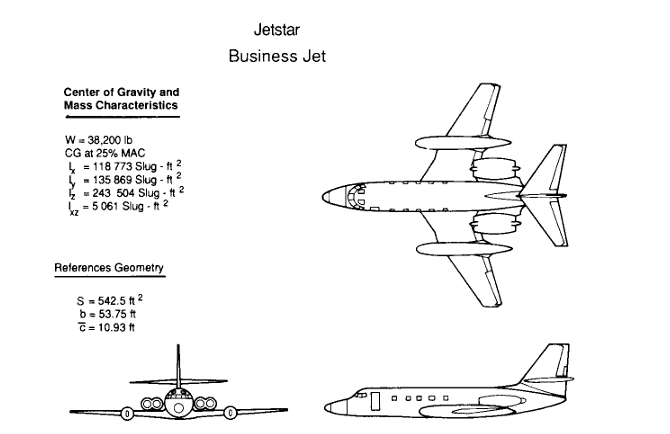

As derivadas de látero-direcionais de estabilidade para condição de cruzeiro de $M = 0.80$ e $H = 40,000 \ ft$ de altitude são apresentadas na tabela abaixo:

Coeficientes |$C_{y_\beta}$| $C_{l_\beta}$  |$C_{n_\beta}$|$C_{l_p}$| $C_{n_p}$|$C_{l_r}$|  
-------------|-------------|----------------|---------|----------|---------|------------|
Valores      | $-0.75$     | $-0.06$        | $0.13$  | $-0.42$  | $-0.756$| $0.04$     |
<b>Coeficientes</b> |$C_{n_r}$|$C_{l_{\delta a}}$| $C_{n_{\delta a}}$|$C_{y_{\delta r}}$| $C_{l_{\delta r}}$| $C_{n_{\delta r}}$|
Valores      | $-0.16$ | $0.060$          | $-0.06$           | $0.16$           | $0.029$           | $-0.057$          |

#### Definindo as propriedades da aeronave

In [13]:
# Propriedades geométricas e de massa da aeronave
W = 38E3
Ix = 118773
Iy = 135869
Iz = 243504
Ixy = 5061

S = 542.5
c = 53.75
b = 10.93

# Coeficientes de estabilidade
Cy_beta = -0.75
Cl_beta = -0.06
Cn_beta =  0.13

Cl_p = -0.42
Cn_p = -0.756

Cl_r = 0.04
Cn_r = -0.16

Cl_delta_a = 0.060
Cn_delta_a = -0.06

Cy_delta_r = 0.16
Cl_delta_r = 0.029
Cn_delta_r = -0.057


# Equação de Estados

A equação de estados para o movimento látero-direcional de uma aeronave em função das deflexões do aileron ($\Delta \delta_a$) e do rudder ($\Delta \delta_r$) é apresentada abaixo, onde $\theta_0$ é o ângulo de arfagem do avião que, para um vôo nivelavo, pode ser assumido igual a zero:

$$
\begin{bmatrix}
\Delta \dot{\beta}\\ 
\Delta \dot{p}\\ 
\Delta \dot{r}\\ 
\Delta \dot{\phi}
\end{bmatrix}

= 

\begin{bmatrix}
 \dfrac{Y_\beta}{u_0} & \dfrac{Y_p}{u_0}  & \left( \dfrac{Y_r}{u_0} - 1\right ) & \dfrac{gcos\theta_0}{u_0} \\ 
 L_\beta & L_p  & L_r  & 0 \\ 
 N_\beta & N_p  & N_r & 0 \\ 
 0 & 1 & 0  & 0 
\end{bmatrix}

\cdot

\begin{bmatrix}
\Delta \beta\\ 
\Delta p\\ 
\Delta r\\ 
\Delta \phi
\end{bmatrix}

+

\begin{bmatrix}
 0 & \dfrac{Y_{\delta_r}}{u_0}\\ 
 L_{\delta_a} & L_{\delta_r} \\ 
 N_{\delta_a} & N_{\delta_r} \\ 
0 & 0
\end{bmatrix}

\cdot

\begin{bmatrix}
\Delta \delta_a\\ 
\Delta \delta_r
\end{bmatrix}
$$

As derivadas laterais presente na equação de estados acima estão relacionadas com os coeficientes de estabilidade como apresentado abaixo, onde $Q = 0.5\rho u_0^2$ é a pressão dinâmica na altura de cruzeiro, $u_0 = c_0M$ a velocidade de cruzeiro da aeronave e $c_0$ a velocidade do som na altura de cruzeiro.

$$
\left\{\begin{matrix}
Y_{[\beta, \delta_r]}  & = & \dfrac{QSC_{y_{[\beta, \delta_r]}}}{m} & (ft/s^2) & Y_{[p,r]} & = & \dfrac{QSbC_{y_{[p,r]}}}{2mu_0} & (ft/s) \\
\ \\
L_{[\beta, \delta_r, \delta_a]} & = & \dfrac{QSbC_{l_{[\beta, \delta_r, \delta_a]}}}{I_x} & (1/s^2) & L_{[p, r]} & = & \dfrac{QSb^2C_{l_{[p,r]}}}{2I_x u_0} & (1/s) \\
\ \\
N_{[\beta, \delta_r, \delta_a]} & = &\dfrac{QSbC_{n_{[\beta, \delta_r, \delta_a]}}}{I_z} & (1/s^2) & N_{[p, r]} & = &\dfrac{QSb^2C_{n_{[p,r]}}}{2I_zu_0} & (1/s) \\
\end{matrix}\right.
$$

A densidade e a velocidade do som depende da temperatura do ambiente que por sua vez, depende da altura de cruzeiro como mostrado abaixo, onde $T_0 = 288.15 \ K$ e $\rho_0 = 1.225 \ kg/m^3$ são a temperatura e densidade do ar no nível do mar, $\lambda = -0.0065 \ K/m$ a constante da variação linear de temperatura da atmosfera, $R = 287.15 \ J/kgK$ a constante específica dos gases e $\gamma = 1.4$ a razão de calores específicos para o ar.
$$
\left\{\begin{matrix}
T = & T_0 + \lambda H & (K) \\
\ \\
\rho = & \rho_0\left(\frac{T}{T_0}\right)^{\frac{-g}{\lambda R} -1} & (kg/m^3) \\
\ \\
c = & \sqrt{\gamma R T} & (m/s)
\end{matrix}\right.
$$

#### Condições de cruzeiro

In [12]:
# Constantes
g       = 9.81
g_fts2  = 32.1850404 
T0      = 288.15
Rsp     = 287.15
rho0    = 1.225
gamma   = 1.4
Lambda  = -0.0065

# Condição atmosférica de cruzeiro
M       = 0.8
H_ft    = 40_000
H       = H_ft*0.3048

T   = T0 + Lambda*H
rho = rho0*(T/T0)**(-g/(Lambda*Rsp)  - 1)
c   = np.sqrt(gamma*Rsp*T)

rho_slug = rho*0.00194
c_ft_s   = c*3.28084

print('Unidade SI:')
print(f'rho = {rho} kg/m^3')
print(f'c = {c} m/s')

print('\nUnidades Imperial:')
print(f'rho = {rho_slug} slug/ft^3')
print(f'c = {c_ft_s} ft/s')

# Condição de cruzeiro
m = W/g_fts2
u0 = c_ft_s*M
Q  = 0.5*rho_slug*u0**2
QS = Q*S

print('\nCondição de cruzeiro:')
print(f'm  = {m} lb')
print(f'u0 = {u0} ft/s')
print(f'Q  = {Q} slug ft/s^2')
print(f'QS = {QS} slug ft^3/s^2')

Unidade SI:
rho = 0.31166593379763347 kg/m^3
c = 289.7942253047841 m/s

Unidades Imperial:
rho = 0.0006046319115674089 slug/ft^3
c = 950.7684861489479 ft/s

Condição de cruzeiro:
m  = 1180.67274509309 lb
u0 = 760.6147889191584 ft/s
Q  = 174.90031828518835 slug ft/s^2
QS = 94883.42266971468 slug ft^3/s^2


#### Sistema por Espaço de Estados

$$
\left\{\begin{matrix}
\dot{x} = A x + Bu \\
y = C x + Du 
\end{matrix}\right.
$$

Sys = <LinearIOSystem>: sys[545]
Inputs (2): ['u[0]', 'u[1]']
Outputs (4): ['y[0]', 'y[1]', 'y[2]', 'y[3]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-7.92423420e-02  0.00000000e+00 -9.48834227e+04  0.00000000e+00]
     [-5.23894728e-01 -2.63492022e-02  2.50944782e-03  0.00000000e+00]
     [ 5.53665875e-01 -2.31340463e-02 -4.89609446e-03  0.00000000e+00]
     [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]]

B = [[ 0.          0.01690503]
     [ 0.52389473  0.25321579]
     [-0.2555381  -0.24276119]
     [ 0.          0.        ]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]]



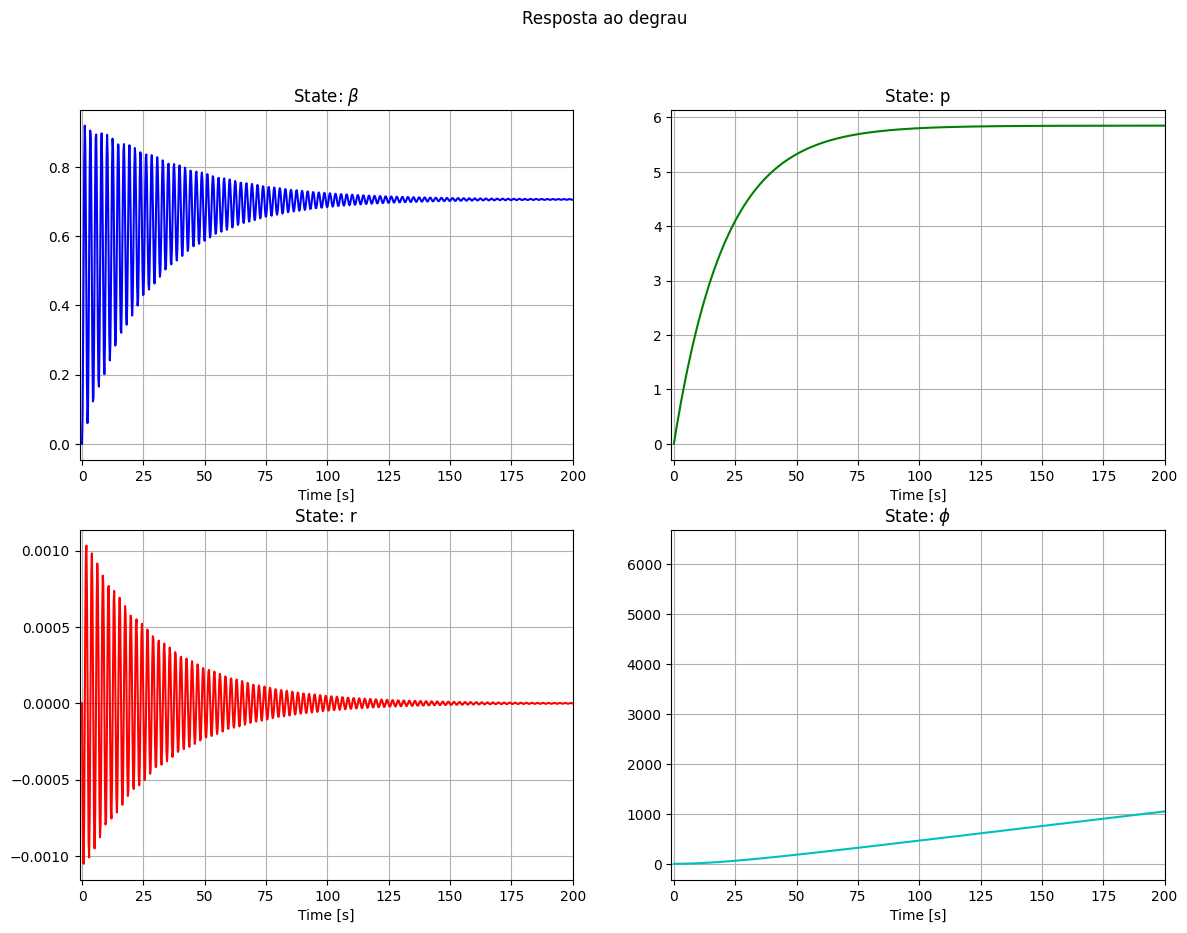

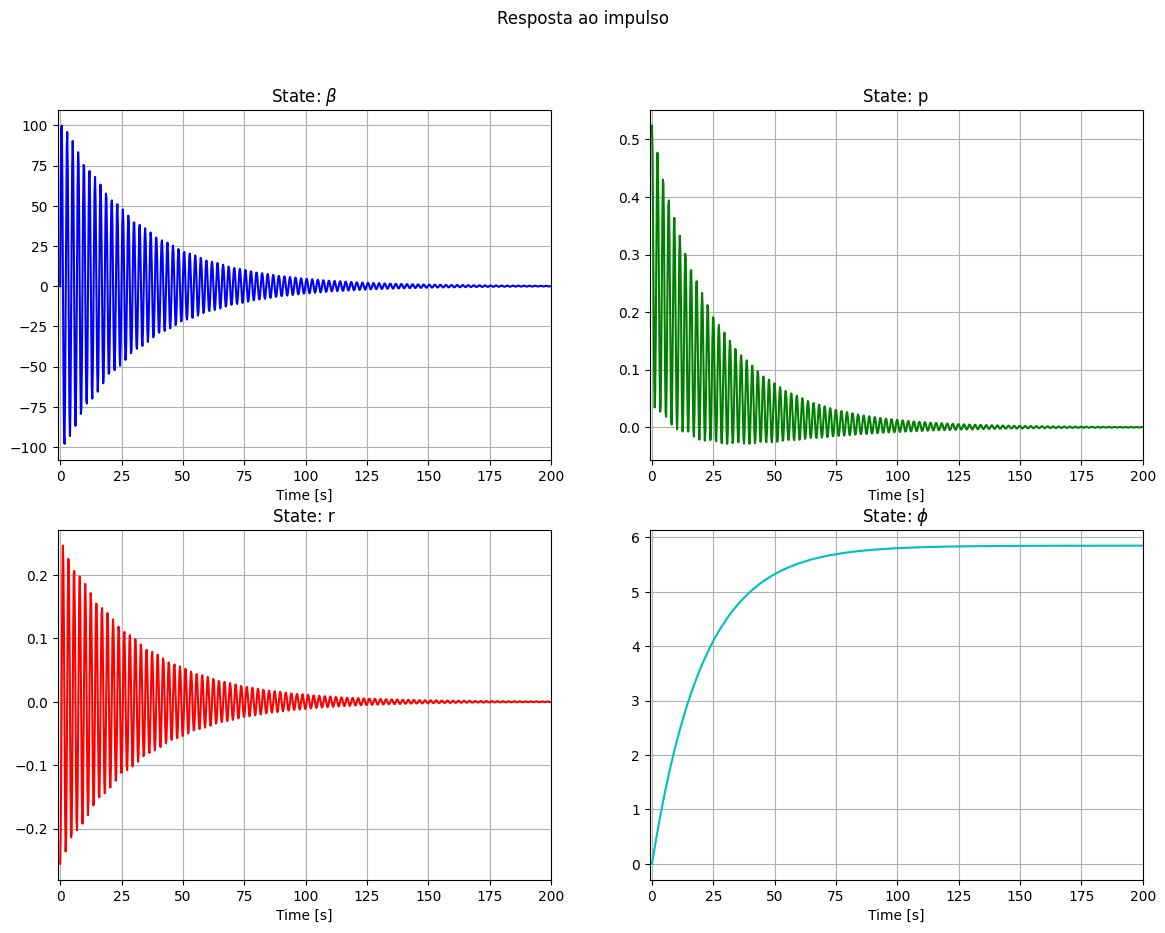

In [260]:

# Matriz A
A = np.empty((4,4))

A[0] = QS*      np.array([Cy_beta/m/u0,             0,            -1,  0])
A[1] = QS*b/Ix* np.array([Cl_beta     , b*Cl_p/(2*u0), b*Cl_r/(2*u0),  0])
A[2] = QS*b/Iz* np.array([Cn_beta     , b*Cn_p/(2*u0), b*Cn_r/(2*u0),  0])
A[3] =          np.array([0           ,             1,             0,  0])

# Matriz B
B = np.empty((4,2))

B[:, 0] = QS*b* np.array([0, Cl_delta_a/Ix, Cn_delta_a/Iz, 0])
B[:, 1] = QS*   np.array([Cy_delta_r/(u0*m), b*Cl_delta_r/Ix, b*Cn_delta_r/Iz, 0])

# Matriz C e D
C = np.diag(np.ones(4))
D = np.zeros((4, 2))

# Sistema por State-space
sys = cm.ss(A, B, C, D)
print(f'Sys = {sys}')

# Resposta ao degrau
yout, t = cm.step(sys)

states = [r'$\beta$', 'p', 'r', r'$\phi$']
with plt.rc_context({'figure.figsize': (14,10)}):
    fig, axes = plt.subplots(2, 2)
    axes = np.reshape(axes, 4)
    for i, state in enumerate(states):
            axes[i].plot(t, yout[:, i, 0], color = COLORS[i])
            
            axes[i].set_title(f'State: {state}')
            axes[i].set_xlabel(f'Time [s]')
            axes[i].set_xlim([-1, 200])
            axes[i].grid()

fig.suptitle('Resposta ao degrau')
plt.show()

# Resposta ao degrau
yout, t = cm.impulse(sys)

states = [r'$\beta$', 'p', 'r', r'$\phi$']
with plt.rc_context({'figure.figsize': (14,10)}):
    fig, axes = plt.subplots(2, 2)
    axes = np.reshape(axes, 4)
    for i, state in enumerate(states):
            axes[i].plot(t, yout[:, i, 0], color = COLORS[i])
            
            axes[i].set_title(f'State: {state}')
            axes[i].set_xlabel(f'Time [s]')
            axes[i].set_xlim([-1, 200])
            axes[i].grid()


fig.suptitle('Resposta ao impulso')
plt.show()

# Controle por realimentação estática de estados


In [274]:
C = np.array([[1,0,0,0],
              [0,0,1,0]])
D = np.zeros((2,2))

# Sistema por State-space
sys_lat_dir = cm.ss(A,B, C, D)
print(f'Sys = {sys_lat_dir}')

# Sistema para rastreamento
row1, col1 = sys_lat_dir.A.shape
row2, col2 = sys_lat_dir.C.shape
row3, col3 = sys_lat_dir.B.shape

Aa = np.zeros((row1+row2, col1+row2))
Aa[:row1, :col1] = sys_lat_dir.A.copy()
Aa[row1:, :col1] = sys_lat_dir.C.copy()

Ba = np.zeros((row3+row2,col3))
Ba[:row3, :] = sys_lat_dir.B.copy()
print(f'Aa = {Aa}')
print(f'Ba = {Ba}')

Sys = <LinearIOSystem>: sys[557]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-7.92423420e-02  0.00000000e+00 -9.48834227e+04  0.00000000e+00]
     [-5.23894728e-01 -2.63492022e-02  2.50944782e-03  0.00000000e+00]
     [ 5.53665875e-01 -2.31340463e-02 -4.89609446e-03  0.00000000e+00]
     [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]]

B = [[ 0.          0.01690503]
     [ 0.52389473  0.25321579]
     [-0.2555381  -0.24276119]
     [ 0.          0.        ]]

C = [[1. 0. 0. 0.]
     [0. 0. 1. 0.]]

D = [[0. 0.]
     [0. 0.]]

Aa = [[-7.92423420e-02  0.00000000e+00 -9.48834227e+04  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.23894728e-01 -2.63492022e-02  2.50944782e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.53665875e-01 -2.31340463e-02 -4.89609446e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.000

#### Estabilidade

[ 0.          +0.j         -0.04823931  +0.j
 -0.03112416+229.20233844j -0.03112416-229.20233844j]


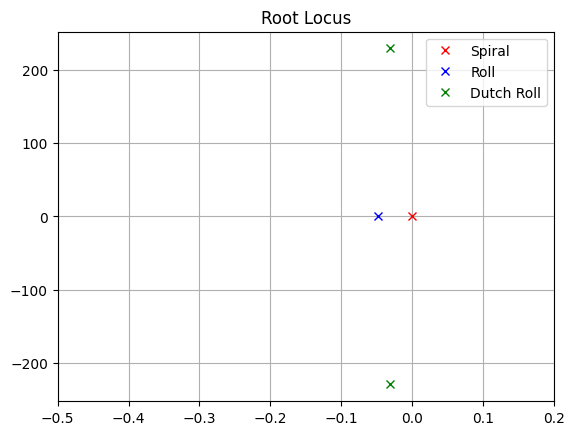

In [251]:
poles = cm.poles(sys_lat_dir)
print(poles)

plt.plot(poles[0].real, poles[0].imag,'rx', label = 'Spiral') 
plt.plot(poles[1].real, poles[1].imag,'bx', label = 'Roll') 
plt.plot(poles[2:].real, poles[2:].imag,'gx', label = 'Dutch Roll') 

plt.title('Root Locus')

plt.xlim([-0.5, 0.2])
# plt.ylim([-400, 400])

plt.legend()
plt.grid()
plt.show()


#### Controlabilidade e Observabilidade

O sistema é tanto obeservável quanto controlável, como mostrado a seguir

In [262]:
co = cm.ctrb(sys_lat_dir.A, sys_lat_dir.B)
Controllability = np.linalg.matrix_rank(co)
print(f'Controllability = {Controllability}')

ob = cm.obsv(sys_lat_dir.A,sys_lat_dir.C)
Observability = np.linalg.matrix_rank(ob)
print(f'Observability = {Observability}')

Controllability = 4
Observability = 3


#### Requisitos de controle
Para um avião Classe II, Categoria B, queremos realizar o controle de modo que a aeronave seja classificada como Nível 1 na qualidade de voo, assim os requisitos para cada modo são estabelicidos abaixo:

- Rolagem: $\tau = 1.4 \ s \Rightarrow \ \lambda_{roll} = -0.71$
- Espiral - Tempo para dobrar de amplitude:  $t = 20 s$
- Rolagem Holandesa: $\zeta\omega_n = 0.15 \ rad/s, \ \omega_n = 0.4 \ rad/s \Rightarrow \ s^2 + 0.3s + 0.16$

A planta já atinge o requisito para o modo espiral apesar de ser instável. É comum na aviação permitir esse tipo de configuração tendo em vista que é um modo mais lento e que o piloto pode agir sobre ele.

#### Alocação de polos pela fórmula de Ackermann

0.4
[-0.08+0.39191836j -0.08-0.39191836j]
Sys = <LinearIOSystem>: sys[562]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-3.66238381e-02  1.48412264e-03 -9.26616042e+04 -4.26653080e-04]
     [-5.14764702e-03 -9.52510183e-02 -3.21322651e+04  6.17010098e-03]
     [ 1.14387096e-07  4.65956806e-06 -7.63650985e-02  1.20591164e-07]
     [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]]

B = [[ 0.          0.01690503]
     [ 0.52389473  0.25321579]
     [-0.2555381  -0.24276119]
     [ 0.          0.        ]]

C = [[1. 0. 0. 0.]
     [0. 0. 1. 0.]]

D = [[0. 0.]
     [0. 0.]]



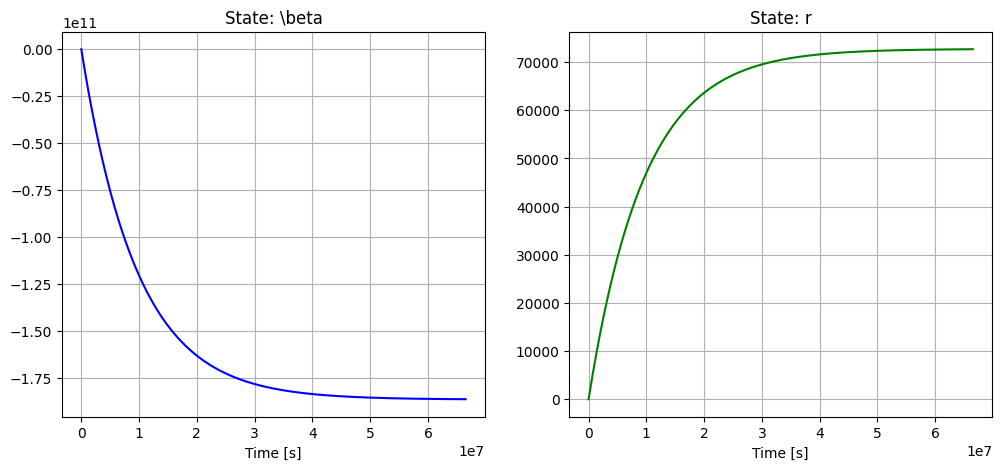

Sys = <LinearIOSystem>: sys[563]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-3.70326638e-02 -1.68853561e-03 -9.44289174e+04  3.31932469e-06]
     [ 7.61753013e-04 -4.93580344e-02 -6.57290814e+03 -4.80050342e-05]
     [ 1.63819167e-06  1.13124834e-07 -1.22848599e-01  1.21863211e-10]
     [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]]

B = [[ 0.          0.01690503]
     [ 0.52389473  0.25321579]
     [-0.2555381  -0.24276119]
     [ 0.          0.        ]]

C = [[1. 0. 0. 0.]
     [0. 0. 1. 0.]]

D = [[0. 0.]
     [0. 0.]]



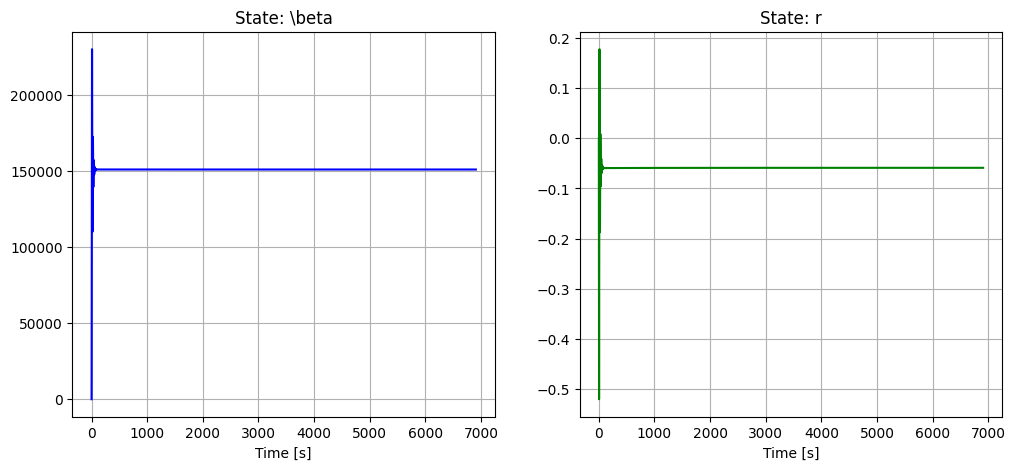

In [278]:
# Polínomio de alocação de polos
zetawn = 0.15
zeta = 0.2
wn = zetawn/(2*zeta) if zetawn/(2*zeta) >=0.4 else 0.4
print(wn)

# Projeto sem rastreamento
dutch_roll_poles = np.poly1d([1, 2*zeta*wn, wn**2]).roots 
print(dutch_roll_poles)
poles_place = np.concatenate((poles[0:2],dutch_roll_poles))
K = cm.place(sys_lat_dir.A,sys_lat_dir.B,poles_place)
sys_lat_dir_without_rast = cm.ss(sys_lat_dir.A - sys_lat_dir.B @ K, sys_lat_dir.B, sys_lat_dir.C, sys_lat_dir.D)

print(f'Sys = {sys_lat_dir_without_rast}')

#Resposta ao Impulso
yout, t = cm.step(sys_lat_dir_without_rast)

states = [r'\beta', 'r']
with plt.rc_context({'figure.figsize':(12,5)}):
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    ax1.plot(t, yout[:, 0, 0], color = COLORS[0])
    ax2.plot(t, yout[:, 1, 0], color = COLORS[1])
    
    ax1.set_title(f'State: {states[0]}')
    ax1.set_xlabel(f'Time [s]')
    ax1.grid()
    
    ax2.set_title(f'State: {states[1]}')
    ax2.set_xlabel(f'Time [s]')
    ax2.grid()
plt.show()


# Projeto com rastreameno
poles_place = np.concatenate(([-0.001,0, 0, poles[1]],dutch_roll_poles))
K = cm.place(Aa,Ba,poles_place)
sys_lat_dir_with_rast = cm.ss(sys_lat_dir.A - sys_lat_dir.B @ K[:,:-2], sys_lat_dir.B, sys_lat_dir.C, sys_lat_dir.D)

print(f'Sys = {sys_lat_dir_with_rast}')

#Resposta ao Impulso
yout, t = cm.step(sys_lat_dir_with_rast)

states = [r'\beta', 'r']
with plt.rc_context({'figure.figsize':(12,5)}):
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    ax1.plot(t, yout[:, 0, 0], color = COLORS[0])
    ax2.plot(t, yout[:, 1, 0], color = COLORS[1])
    
    ax1.set_title(f'State: {states[0]}')
    ax1.set_xlabel(f'Time [s]')
    ax1.grid()
    
    ax2.set_title(f'State: {states[1]}')
    ax2.set_xlabel(f'Time [s]')
    ax2.grid()
plt.show()


[-0.075     +0.93449518j -0.075     -0.93449518j -0.001     +0.j
 -0.71428571+0.j        ]
Sys = <LinearIOSystem>: sys[512]
Inputs (2): ['u[0]', 'u[1]']
Outputs (4): ['y[0]', 'y[1]', 'y[2]', 'y[3]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-2.99411856e-02  4.22777339e-02 -9.50589173e+04 -2.22618330e-05]
     [-1.01811532e-01 -6.85197187e-01  2.53834078e+03  3.22144656e-04]
     [ 8.86171862e-06 -4.98524719e-06 -1.50147344e-01 -9.23148808e-08]
     [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]]

B = [[ 0.          0.01690503]
     [ 0.52389473  0.25321579]
     [-0.2555381  -0.24276119]
     [ 0.          0.        ]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]]

[-0.075     +0.93449529j -0.075     -0.93449529j -0.71428571+0.j
 -0.001     +0.j        ]


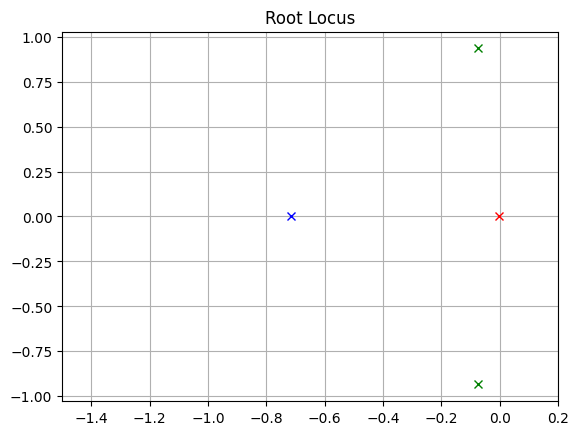

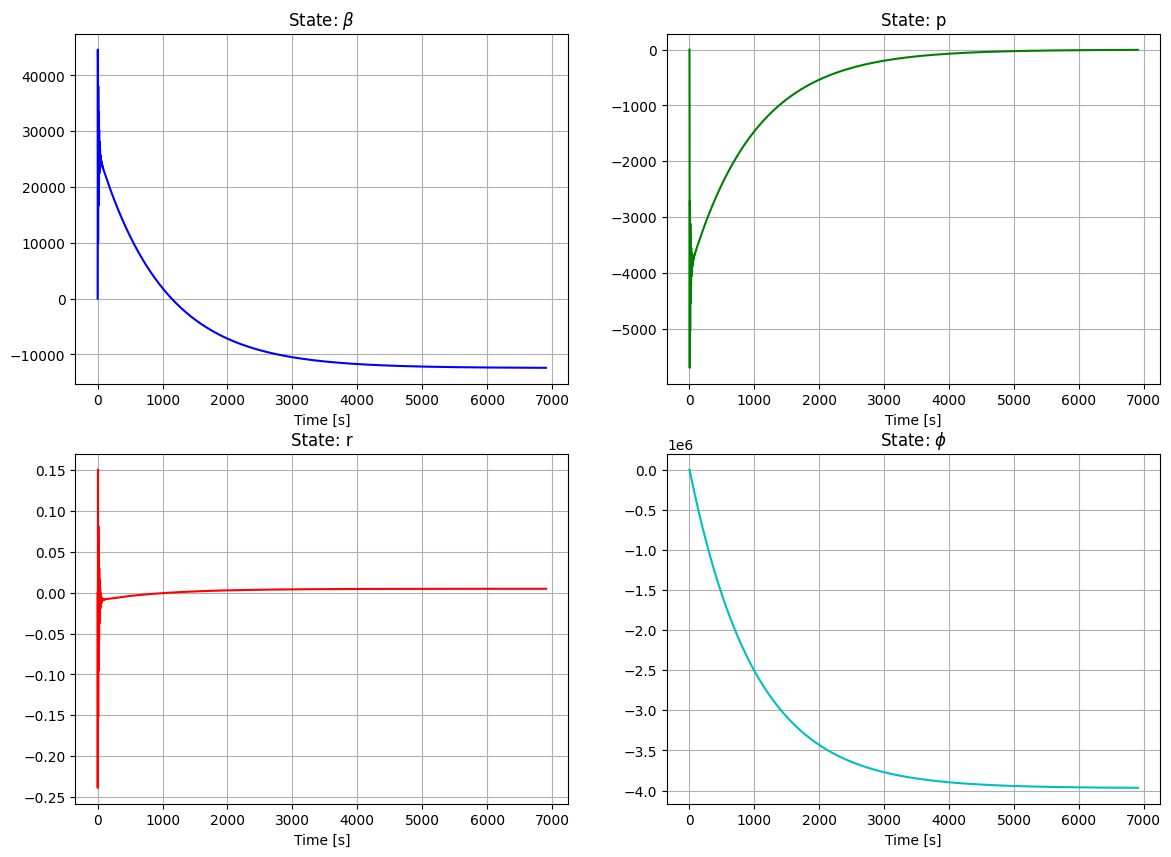

In [215]:
# Polínomio de alocação de polos
zetawn = 0.15
zeta = 0.08
wn = zetawn/(2*zeta)

dutch_roll_poles = np.poly1d([1, 2*zeta*wn, wn**2]).roots 
pole_roll = -1/1.4
poles_place = np.concatenate((dutch_roll_poles,[-0.001, pole_roll]))
print(poles_place)

# Projeto de realimentação sem rastreamento
K = cm.place(A,B,poles_place)
Amf = A - B @ K
sys_lat_dir_without_rast = cm.ss(Amf, B, C, D)

print(f'Sys = {sys_lat_dir_without_rast}')

poles = cm.poles(sys_lat_dir_without_rast)
print(poles)

plt.plot(poles[0:2].real, poles[0:2].imag,'gx', label = 'Dutch Rool') 
plt.plot(poles[2].real, poles[2].imag,'bx', label = 'Roll') 
plt.plot(poles[3].real, poles[3].imag,'rx', label = 'Spiral') 

plt.title('Root Locus')

plt.xlim([-1.5, 0.2])
# plt.ylim([-1.5, 1.5])

plt.grid()
plt.show()

#Resposta ao degrau
yout, t = cm.step(sys_lat_dir_without_rast)

states = [r'$\beta$', 'p', 'r', r'$\phi$']
with plt.rc_context({'figure.figsize': (14,10)}):
    fig, axes = plt.subplots(2, 2)
    axes = np.reshape(axes, 4)
    for i, state in enumerate(states):
            axes[i].plot(t, yout[:, i, 0], color = COLORS[i])
            
            axes[i].set_title(f'State: {state}')
            axes[i].set_xlabel(f'Time [s]')
            axes[i].grid()


plt.show()

# row1,col1 = A.shape
# row2,col2 = C.shape
# Aa = np.zeros((row1+row2, col1+1))
# Aa[:row1, :col1] = A.copy()
# Aa[row1:row1+row2, :col1] = -C.copy()


# Ba = np.zeros((row1+row2,2))
# Ba[:row1, :] = B.copy()
# print(Ba)



In [214]:
pole_roll

-0.7142857142857143